In [32]:
import os
import sys

import numpy as np
import pandas as pd

import paths
import pickle
import importlib

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from streamfunction_ecco import streamfunction_custom_utils as strf_utils

import matplotlib.pyplot as plt

In [2]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]

In [3]:
# A helper function to subset 30S, since now the surface vars exist for all longitudes - values taken from basin function!
def mask_30S(inputs):
    mask = np.logical_or(np.logical_or(np.logical_and(inputs.longitude >= -180, 
                                                      inputs.longitude <= -71),
                                       np.logical_and(inputs.longitude >= 31, 
                                                      inputs.longitude <= 115)),
                         np.logical_and(inputs.longitude >= 153, 
                                        inputs.longitude <= 180))
    masked = inputs.where(mask, drop = True)

    return masked

In [9]:
lat = lats[1]
lat_str = strf_utils.format_lat_lon(lat)

inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat_str}.nc").isel(latitude=slice(1,2))
inputs = mask_30S(inputs)
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 440)
Coordinates:
  * latitude   (latitude) float32 -29.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 0.4738 0.4738 ... 0.6051
    ZWS        (time, latitude, longitude) float32 -0.0341 -0.0341 ... -0.05642
    OBP        (time, latitude, longitude) float32 6.537 6.537 ... 12.21 12.21
    SSS        (time, latitude, longitude) float32 35.6 35.6 ... 35.81 35.81
    SST        (time, latitude, longitude) float32 22.63 22.63 ... 21.72 21.72

In [10]:
#outputs = xr.open_dataset(f"{data_home}/streamfunctions_ecco/{lat}/PSI_residual{lat}.nc")
extra_str = 'moc'
outputs_fp = f"{data_home}/ecco_data_minimal/{lat_str}_{extra_str}_density.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f).astype(np.float64)
outputs = np.expand_dims(outputs, 1) # grabbing just 30S
print(outputs.shape)

outputs = xr.Dataset(data_vars = {'moc' : (["time", "latitude"], outputs)}, coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-60),})

outputs

(312, 1)


<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int32 -60
Data variables:
    moc       (time, latitude) float64 -22.84 -21.31 -22.59 ... -20.17 -23.13

In [11]:
np.unique(inputs.SSH.values, return_counts=True)

(array([0.07409389, 0.07609812, 0.07878798, ..., 0.95895165, 0.96344155,
        0.96580803], dtype=float32),
 array([2, 2, 2, ..., 2, 2, 2], dtype=int64))

In [12]:
date_range = (inputs.time.values[0], inputs.time.values[-1]) # grabbing start and end date for inputs
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

Date range to align to: ('1992-01-16', '2017-12-16')


In [25]:
# apply whatever preprocessing we want *before* calling reshape_inputs
pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_np = reshape_inputs(pp_data, history=6, keep_coords=["time", "longitude"])

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
X = pp_data_np
    
# Necessary step to do convolutions along the right axis with pytorch tensors!
dims = list(range(X.ndim))  
dims[1], dims[-1] = dims[-1], dims[1]
X = np.transpose(X, dims)

conv_dims = 1
if len(X.shape) == (conv_dims + 1):
    X = np.expand_dims(X, axis=-1)

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

axes: ['time', 'history', 'longitude', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (307, 6, 440, 5)

Inputs shape: (307, 5, 440, 6)
Outputs shape: (307,)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

Xt_train = t.tensor(X_train, device=device).double()
Yt_train = t.tensor(y_train, device=device).double()
Xt_valid = t.tensor(X_valid, device=device).double()
Yt_valid = t.tensor(y_valid, device=device).double()
Xt_test = t.tensor(X_test, device=device).double()
Yt_test = t.tensor(y_test, device=device).double()

device: cpu


In [27]:
import importlib
from models import train_alt, SimDataset, CNN1D, CNN2D, CNN3D

importlib.reload(train_alt)
importlib.reload(CNN1D)
importlib.reload(CNN2D)
importlib.reload(SimDataset)

<module 'models.SimDataset' from 'C:\\Users\\aline\\OTP\\models\\SimDataset.py'>

In [36]:
dropout = 0.2
n_pure_layers = 1
n_mix_layers = 1
n_features = 5
n_channels = n_features * 5
kernel_size = 3
model_iterations = 1

def train_CNN():

    model = CNN2D.CNN2D(
        n_pure_layers=n_pure_layers, 
        n_mix_layers=n_mix_layers, 
        n_features=n_features, 
        n_channels=n_channels,
        kernel_size=kernel_size,
        dropout=dropout
    ).double()

    model, train_loss, val_loss = train_alt.train_model(
        model=model, 
        X_train = Xt_train, 
        y_train = Yt_train, 
        X_val = Xt_valid,
        y_val = Yt_valid, 
        early_stopping=True,
        patience=2000,
    )
    return model

models = []
for i in range(model_iterations):
    models.append(train_CNN())

device: cpu
1551 parameters.


100%|██████████| 5000/5000 [20:26<00:00,  4.08it/s]  


In [37]:
def predict_CNN(model):

    # Extracting all predictions in time order
    train_set_pred = train_alt.predict(model, Xt_train, Yt_train)
    valid_set_pred = train_alt.predict(model, Xt_valid, Yt_valid)
    test_set_pred = train_alt.predict(model, Xt_test, Yt_test)
    
    predictions = {
        "train_set_pred": train_set_pred, 
        "valid_set_pred": valid_set_pred, 
        "test_set_pred": test_set_pred, 
        "all_preds": np.concatenate([train_set_pred, valid_set_pred, test_set_pred])
    }
    
    metrics = {
        "r2": round(r2_score(test_set_pred, y_test), 3),
        "mse": round(mean_squared_error(test_set_pred, y_test), 3),
        "rmse": round(root_mean_squared_error(test_set_pred, y_test), 3),
        "mae": round(mean_absolute_error(test_set_pred, y_test), 3),
        "mape": round(mean_absolute_percentage_error(test_set_pred, y_test), 3)*100,
        #"cmape": round(custom_MAPE(test_set_pred, y_test), 3),
        "test_corr": round(np.corrcoef(np.array(test_set_pred).squeeze(), y_test)[0, 1], 3),
        "train_corr": round(np.corrcoef(np.array(train_set_pred).squeeze(), y_train)[0, 1], 3)
        }
    
    return predictions, metrics

predictions_models = []
metrics_models = []

for i in range(len(models)):
    predictions, metrics = predict_CNN(models[i])
    predictions_models.append(predictions)
    metrics_models.append(metrics)

metrics_df = pd.DataFrame(metrics_models)
summary_metrics_df = pd.DataFrame({
                "mean": metrics_df.mean().round(3), 
                "std": metrics_df.std().round(3)}
            )
display(summary_metrics_df)

predictions_df = pd.DataFrame(predictions_models)

,mean,std
r2,0.335,NaN
mse,15.058,NaN
rmse,3.880,NaN
mae,3.035,NaN
mape,17.700,NaN
test_corr,0.912,NaN
train_corr,0.909,NaN


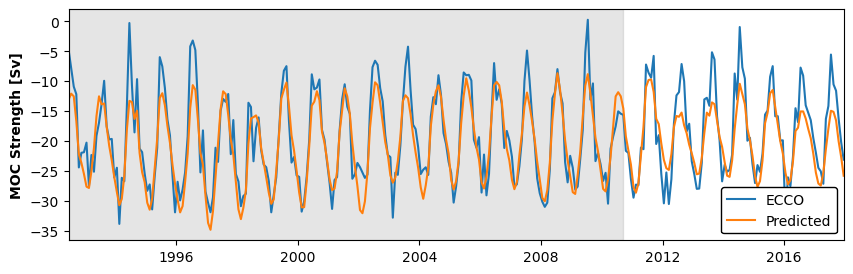

In [38]:
mean_arrays = {col: np.mean(np.stack(predictions_df[col].values), axis=0) for col in predictions_df}
all_preds = mean_arrays['all_preds']
time = outputs.time.values[-X.shape[0]:]
fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

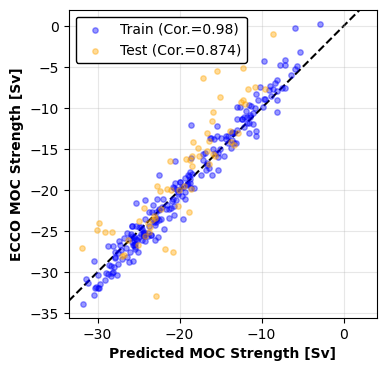

In [35]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(mean_arrays['train_set_pred']).squeeze()
y_pred_test = np.array(mean_arrays['test_set_pred']).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()